In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pickle 
from tqdm import tqdm

import automata as dfa
import utils

## Global Variables

In [2]:
ATT_PATH = "./data/languages/att/"
DATA_PATH = "./data/Small/"
NAMES_PATH = "./names.txt"

BATCH_SIZE = 100

N_EPOCH = 150
EPOCH_VERBOSE = 50
LEARNING_RATES = 0.001

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

## Load the datas

In [3]:
names, extensions = utils.lang_names(NAMES_PATH)
print(names, extensions, sep="\n")

datas = dict()
automata = dict()
for name in names:
    datas[name], automata[name] = utils.data_automata_loading(ATT_PATH, DATA_PATH, name, extensions, return_automata=True)

['04.03.TLTT.2.3.0', '04.03.TLTT.4.2.3', '04.04.Reg.0.0.9', '04.04.Zp.2.1.0', '16.04.TLT.2.1.4', '16.16.LT.4.1.5', '16.16.SP.2.1.0', '64.64.SF.0.0.0', '64.64.SL.4.1.0']
['_Dev', '_TestLA', '_TestLR', '_TestSA', '_TestSR', '_Train']


In [4]:
def makeloader(name:str, datas)-> tuple[DataLoader, list[torch.Tensor]]:
    train = DataLoader(datas[name]["_Train"], BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(datas[name]["_Dev"], len(datas[name]["_Dev"]))))

    return train, test

## Model

In [5]:
def single_model_training(model:nn.Module, optim:torch.optim.Optimizer, loss:nn.Module, target:list[torch.Tensor], trainloader:DataLoader, test:list[torch.Tensor]):

    statsdict = utils.initstats(utils.STATS_NAMES)

    for batchepoch in range(N_EPOCH//EPOCH_VERBOSE):
        for _ in tqdm(range(EPOCH_VERBOSE), desc=f"Epoch {batchepoch*EPOCH_VERBOSE + 1} to {(batchepoch+1)*EPOCH_VERBOSE}...", ncols=75):
            for words, lengths, labels in trainloader:
                labels = labels.to(dtype = torch.float32)

                out = model(words, lengths)

                newloss = loss(out, labels)
                newloss.backward()
                statsdict["losses"].append(newloss.item())

                stats = utils.stats(model, target, LEARNING_RATES)
                statsdict["l2"].append(stats[0])
                statsdict["linf"].append(stats[1])
                statsdict["linedist"].append(stats[2])
                statsdict["targetdist"].append(stats[3])
                

                optim.step()
                optim.zero_grad()

            with torch.no_grad():
                predictions = model.predict(test[0], test[1])
                statsdict["acc"].append(torch.sum(predictions == test[2].reshape(-1), dim=0).item() * 100 / len(test[2]))
        print(f"Done! Trainloss: {statsdict['losses'][-1]:.6f}, Test accuracy: {statsdict['acc'][-1]:.4f}")

    return statsdict



def train_and_stats(name:str, datas:dict[dict[dfa.TorchData]], automaton:dfa.DFA, loss = nn.BCELoss(), optimizer = torch.optim.Adam, returnmodel=False):
    
    
    trainloader, test = makeloader(name, datas)
    target = dfa.sigmoid_to_tanh(dfa.dfa2srn(automaton.transition.T, automaton.finites))

    noparam = dfa.AutomataRNN(automaton, device=DEVICE).to(DEVICE)
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    statsnoparam = single_model_training(noparam, optim, loss, target, trainloader, test)

    print("\nNon parametrized RNN done!\n")

    withparam = dfa.ParametrizeRNN(automaton, device=DEVICE).to(DEVICE)

    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)
    optim.zero_grad()

    statsparam = single_model_training(withparam, optim, loss, target, trainloader, test)
    print("\nParametrized RNN done!")

    if returnmodel:
        return (statsnoparam, noparam), (statsparam, withparam)
    else:
        return statsnoparam, statsparam
            

In [6]:
def save_stats(path:str, all_stats, **parameters):
    with open(path, "wb") as file:
        pickle.dump([parameters, all_stats], file)

## Training

In [20]:
(statsnoparam, noparam), (statsparam, withparam) = train_and_stats(names[1], datas, automata[names[1]], returnmodel=True)

Epoch 1 to 10...: 100%|████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Done! Trainloss: 0.612192, Test accuracy: 63.5000


Epoch 11 to 20...: 100%|███████████████████| 10/10 [00:02<00:00,  3.38it/s]


Done! Trainloss: 0.587448, Test accuracy: 63.8000


Epoch 21 to 30...: 100%|███████████████████| 10/10 [00:02<00:00,  3.47it/s]


Done! Trainloss: 0.622309, Test accuracy: 64.0000


Epoch 31 to 40...: 100%|███████████████████| 10/10 [00:02<00:00,  3.84it/s]


Done! Trainloss: 0.631250, Test accuracy: 63.2000


Epoch 41 to 50...: 100%|███████████████████| 10/10 [00:02<00:00,  3.86it/s]


Done! Trainloss: 0.604726, Test accuracy: 62.9000


Epoch 51 to 60...: 100%|███████████████████| 10/10 [00:02<00:00,  3.65it/s]


Done! Trainloss: 0.568955, Test accuracy: 62.0000


Epoch 61 to 70...: 100%|███████████████████| 10/10 [00:02<00:00,  3.88it/s]


Done! Trainloss: 0.640668, Test accuracy: 63.2000


Epoch 71 to 80...: 100%|███████████████████| 10/10 [00:02<00:00,  3.84it/s]


Done! Trainloss: 0.604636, Test accuracy: 62.5000


Epoch 81 to 90...: 100%|███████████████████| 10/10 [00:02<00:00,  3.60it/s]


Done! Trainloss: 0.628350, Test accuracy: 62.0000


Epoch 91 to 100...: 100%|██████████████████| 10/10 [00:02<00:00,  4.04it/s]


Done! Trainloss: 0.601487, Test accuracy: 62.5000


Epoch 101 to 110...: 100%|█████████████████| 10/10 [00:02<00:00,  3.81it/s]


Done! Trainloss: 0.643747, Test accuracy: 62.2000


Epoch 111 to 120...: 100%|█████████████████| 10/10 [00:02<00:00,  3.79it/s]


Done! Trainloss: 0.535176, Test accuracy: 63.2000


Epoch 121 to 130...: 100%|█████████████████| 10/10 [00:02<00:00,  3.70it/s]


Done! Trainloss: 0.617689, Test accuracy: 63.1000


Epoch 131 to 140...: 100%|█████████████████| 10/10 [00:02<00:00,  3.76it/s]


Done! Trainloss: 0.540765, Test accuracy: 64.0000


Epoch 141 to 150...: 100%|█████████████████| 10/10 [00:02<00:00,  3.91it/s]


Done! Trainloss: 0.625238, Test accuracy: 64.4000

Non parametrized RNN done!



Epoch 1 to 10...: 100%|████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Done! Trainloss: 0.693462, Test accuracy: 49.8000


Epoch 11 to 20...: 100%|███████████████████| 10/10 [00:02<00:00,  3.68it/s]


Done! Trainloss: 0.694130, Test accuracy: 49.8000


Epoch 21 to 30...: 100%|███████████████████| 10/10 [00:02<00:00,  3.67it/s]


Done! Trainloss: 0.687427, Test accuracy: 49.7000


Epoch 31 to 40...: 100%|███████████████████| 10/10 [00:02<00:00,  3.66it/s]


Done! Trainloss: 0.684327, Test accuracy: 49.7000


Epoch 41 to 50...: 100%|███████████████████| 10/10 [00:03<00:00,  2.93it/s]


Done! Trainloss: 0.692059, Test accuracy: 49.7000


Epoch 51 to 60...: 100%|███████████████████| 10/10 [00:02<00:00,  3.36it/s]


Done! Trainloss: 0.700031, Test accuracy: 49.7000


Epoch 61 to 70...: 100%|███████████████████| 10/10 [00:02<00:00,  3.46it/s]


Done! Trainloss: 0.699856, Test accuracy: 49.7000


Epoch 71 to 80...: 100%|███████████████████| 10/10 [00:02<00:00,  3.41it/s]


Done! Trainloss: 0.687702, Test accuracy: 49.7000


Epoch 81 to 90...: 100%|███████████████████| 10/10 [00:03<00:00,  3.31it/s]


Done! Trainloss: 0.687790, Test accuracy: 49.7000


Epoch 91 to 100...: 100%|██████████████████| 10/10 [00:02<00:00,  3.70it/s]


Done! Trainloss: 0.693438, Test accuracy: 49.7000


Epoch 101 to 110...: 100%|█████████████████| 10/10 [00:03<00:00,  2.56it/s]


Done! Trainloss: 0.694010, Test accuracy: 49.7000


Epoch 111 to 120...: 100%|█████████████████| 10/10 [00:03<00:00,  2.62it/s]


Done! Trainloss: 0.695675, Test accuracy: 49.7000


Epoch 121 to 130...: 100%|█████████████████| 10/10 [00:03<00:00,  2.85it/s]


Done! Trainloss: 0.686915, Test accuracy: 49.7000


Epoch 131 to 140...: 100%|█████████████████| 10/10 [00:03<00:00,  2.73it/s]


Done! Trainloss: 0.677922, Test accuracy: 49.8000


Epoch 141 to 150...: 100%|█████████████████| 10/10 [00:03<00:00,  2.86it/s]

Done! Trainloss: 0.682686, Test accuracy: 55.0000

Parametrized RNN done!


In [7]:
all_stats = dict()
for name in names:
    print(f"{name} training...")
    all_stats[name] = train_and_stats(name, datas, automata[name], loss = dfa.Binary_nthRoot_Loss())
    save_stats("saved_mlreg_stats2.pkl", all_stats, lr = LEARNING_RATES, epoch = N_EPOCH, optim = "Adam", loss = "nthRoot", batch_size = BATCH_SIZE)


04.03.TLTT.2.3.0 training...


Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:17<00:00,  2.92it/s]


Done! Trainloss: 0.488785, Test accuracy: 55.1000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:16<00:00,  2.95it/s]


Done! Trainloss: 0.223723, Test accuracy: 78.1000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:16<00:00,  3.00it/s]


Done! Trainloss: 0.172584, Test accuracy: 78.9000

Non parametrized RNN done!



Epoch 1 to 50...: 100%|████████████████████| 50/50 [00:17<00:00,  2.84it/s]


Done! Trainloss: 0.524459, Test accuracy: 50.0000


Epoch 51 to 100...: 100%|██████████████████| 50/50 [00:18<00:00,  2.69it/s]


Done! Trainloss: 0.551328, Test accuracy: 50.0000


Epoch 101 to 150...: 100%|█████████████████| 50/50 [00:19<00:00,  2.51it/s]


Done! Trainloss: 0.530692, Test accuracy: 50.0000

Parametrized RNN done!
04.03.TLTT.4.2.3 training...


Epoch 1 to 50...:  10%|██                   | 5/50 [00:02<00:22,  1.96it/s]


KeyboardInterrupt: 

In [7]:
with open("saved_mlreg_stats1.pkl", 'rb') as file:
    parameters, all_stats = pickle.load(file)

In [8]:
parameters

{'lr': 0.001, 'epoch': 150, 'optim': 'Adam', 'loss': 'BCE', 'batch_size': 100}

## Plots

04.03.TLTT.2.3.0


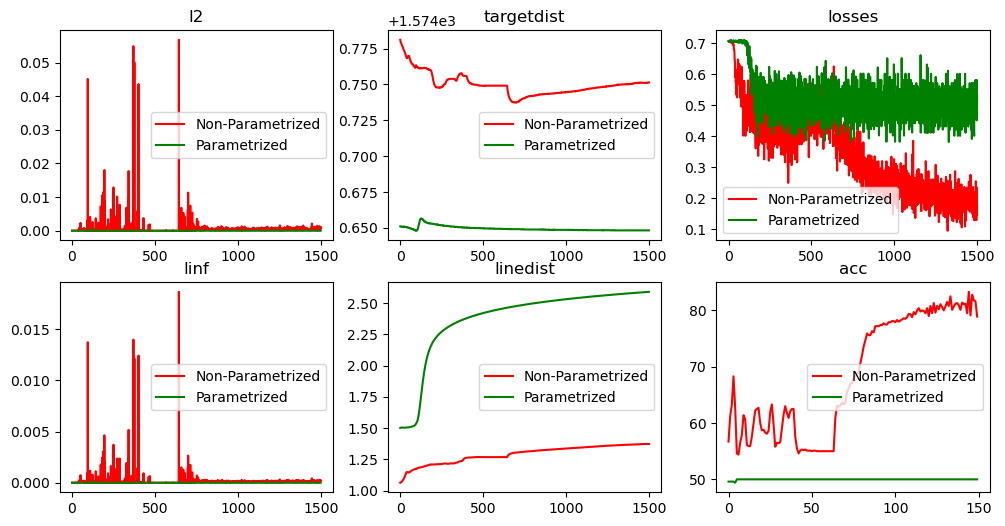

In [8]:
statsnoparam, statsparam = all_stats[names[0]]
#utils.plot_stats(statsnoparam)
#utils.plot_stats(statsparam)
print(names[0])
utils.plot_stats(statsnoparam, statsparam)

04.03.TLTT.2.3.0


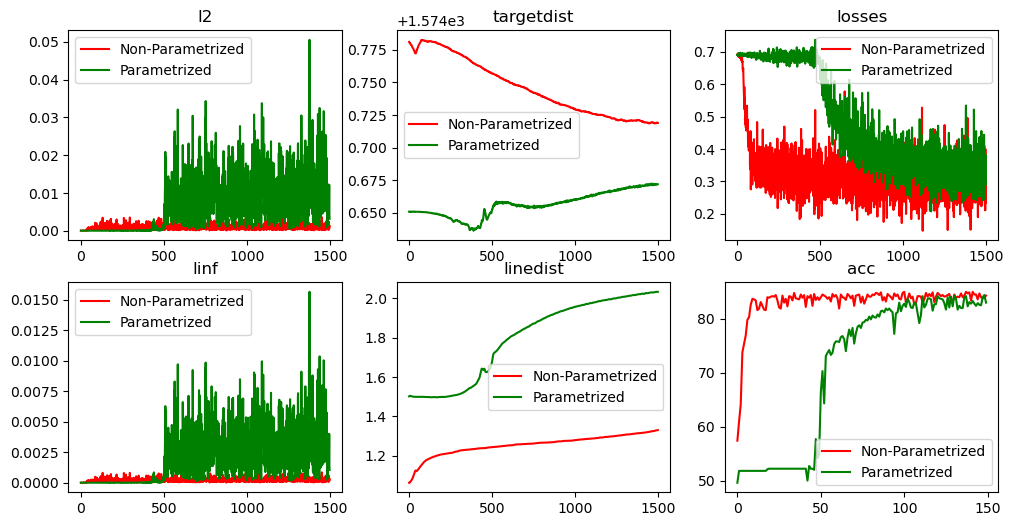

04.03.TLTT.4.2.3


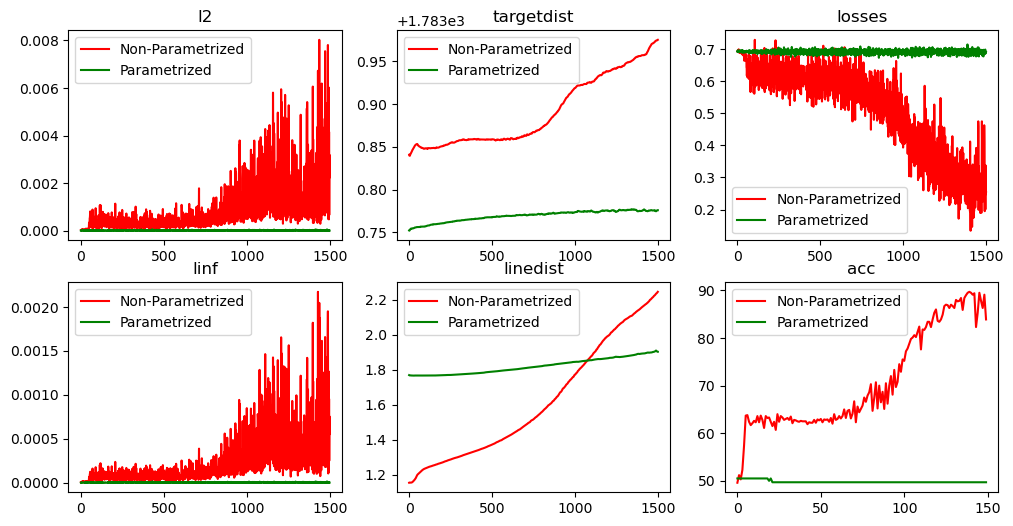

04.04.Reg.0.0.9


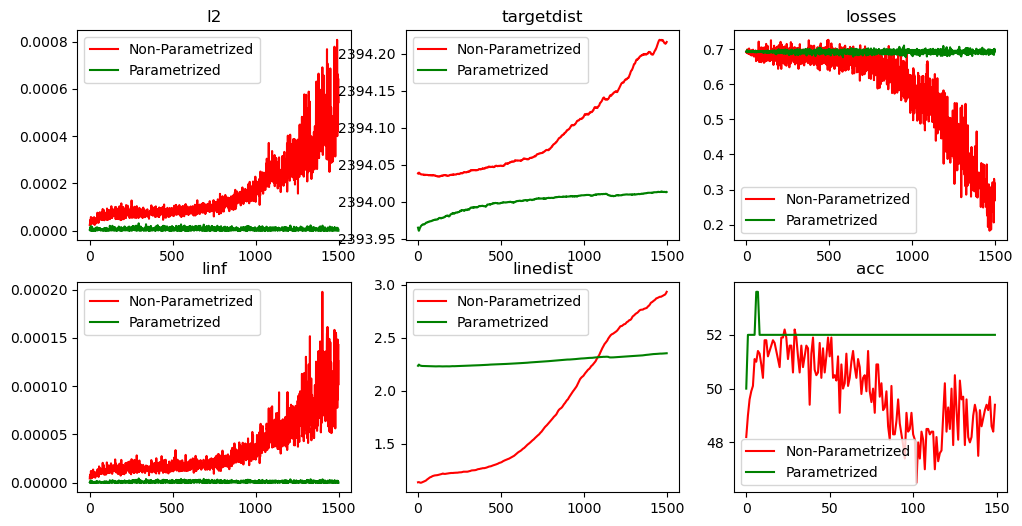

04.04.Zp.2.1.0


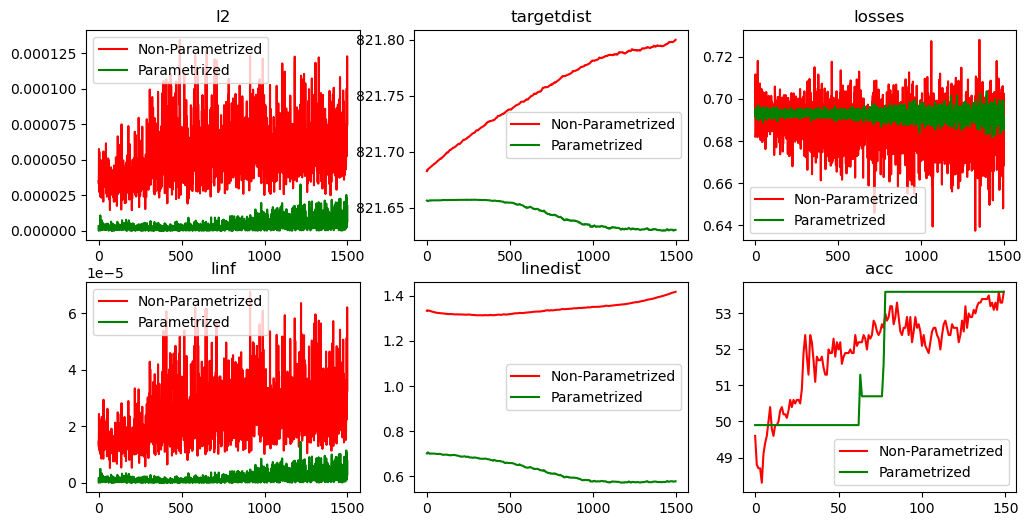

16.04.TLT.2.1.4


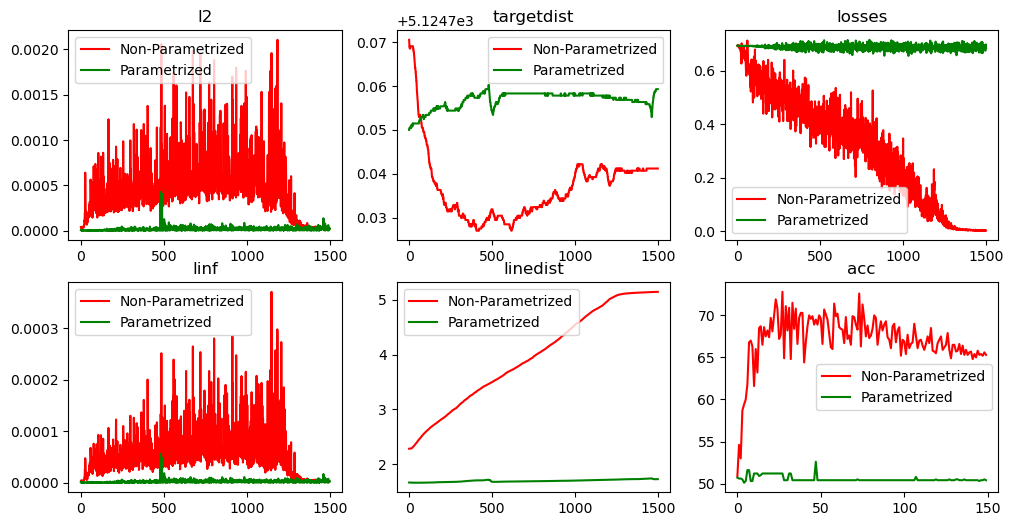

16.16.LT.4.1.5


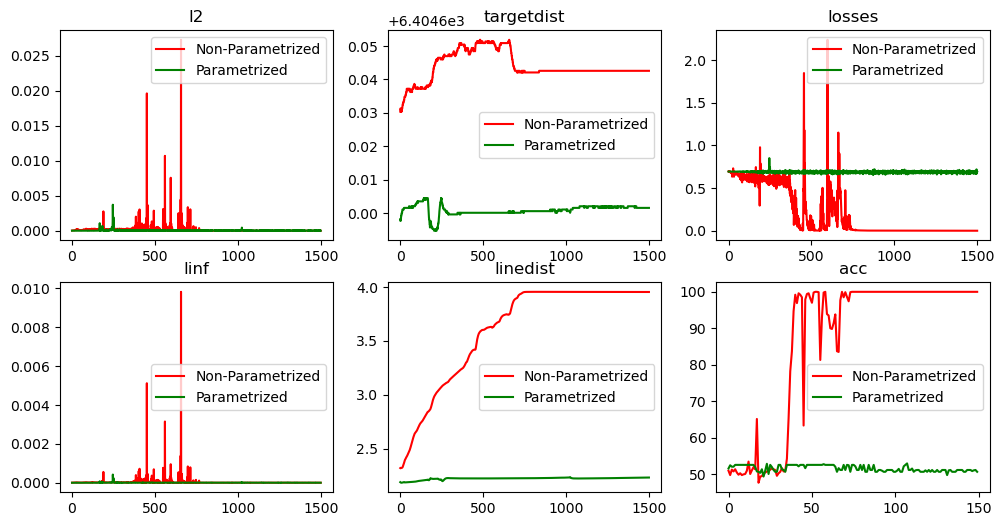

16.16.SP.2.1.0


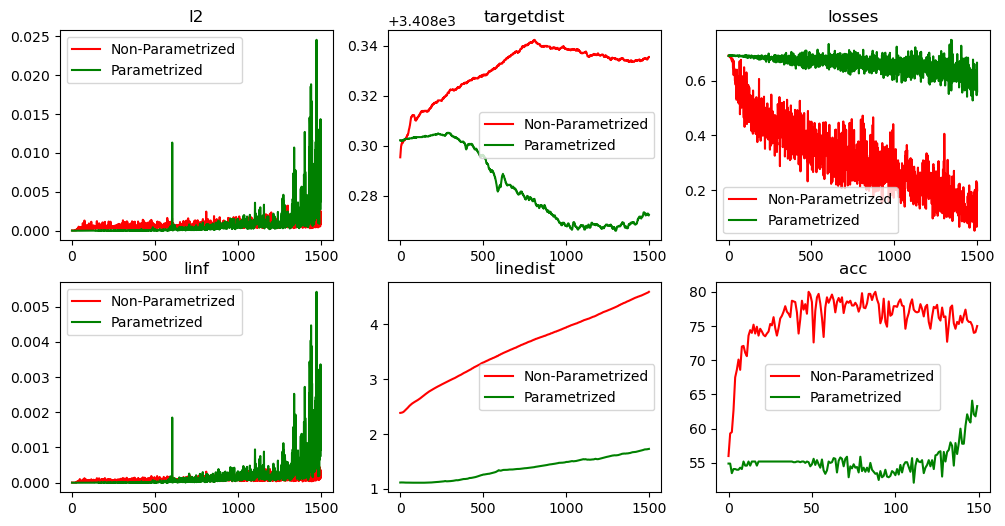

64.64.SF.0.0.0


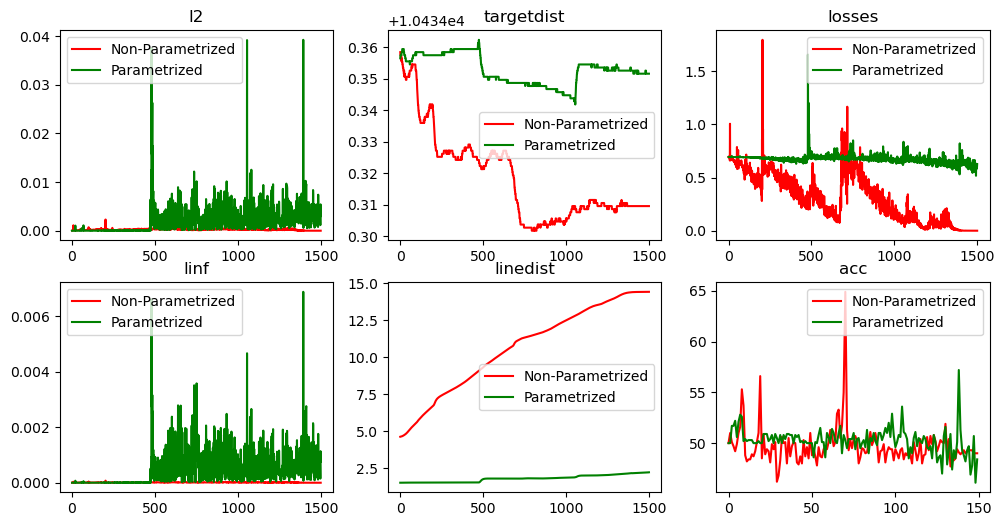

64.64.SL.4.1.0


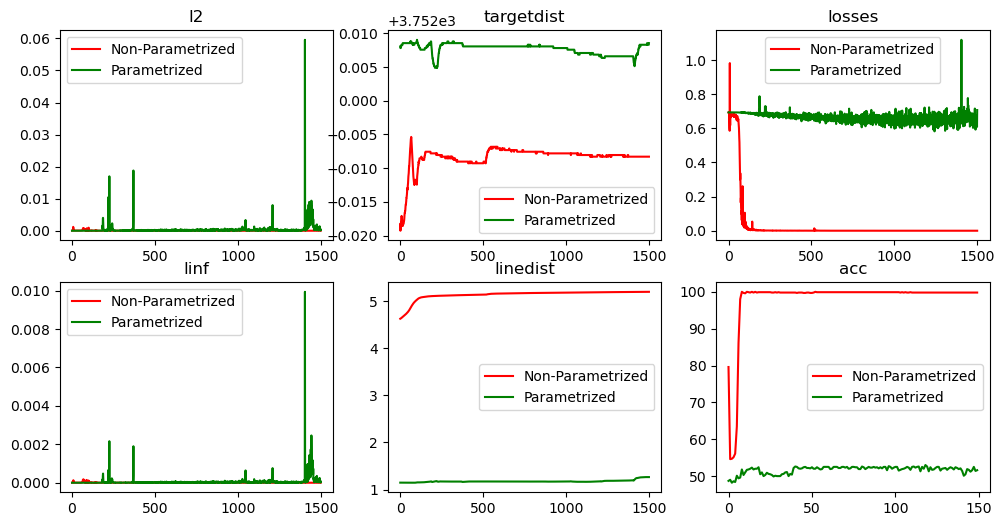

In [9]:
for name in names:
    statsnoparam, statsparam = all_stats[name]
    #utils.plot_stats(statsnoparam)
    #utils.plot_stats(statsparam)
    print(name)
    utils.plot_stats(statsnoparam, statsparam)